In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

# Read the data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


# 1. EDA

In [3]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [4]:
train_data.describe()


,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614503,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


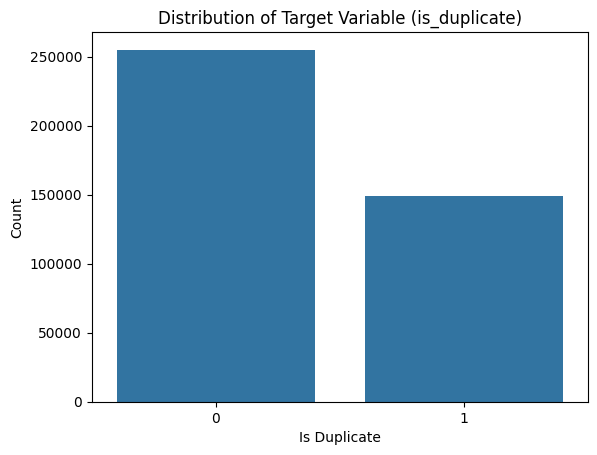

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='is_duplicate', data=train_data)
plt.title('Distribution of Target Variable (is_duplicate)')
plt.xlabel('Is Duplicate')
plt.ylabel('Count')
plt.show()


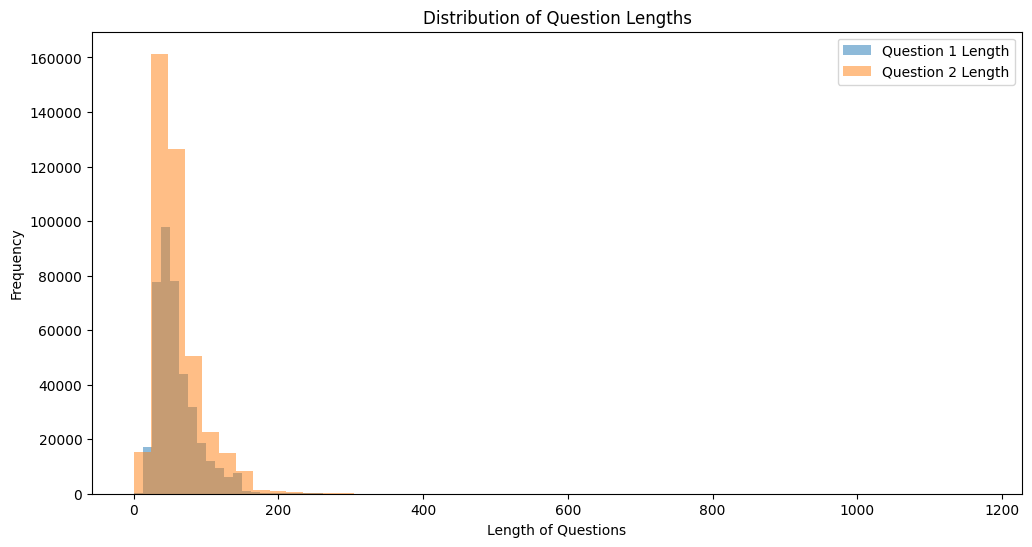

In [6]:
train_data['question1_length'] = train_data['question1'].apply(lambda x: len(str(x)))
train_data['question2_length'] = train_data['question2'].apply(lambda x: len(str(x)))

plt.figure(figsize=(12, 6))
plt.hist(train_data['question1_length'], bins=50, alpha=0.5, label='Question 1 Length')
plt.hist(train_data['question2_length'], bins=50, alpha=0.5, label='Question 2 Length')
plt.title('Distribution of Question Lengths')
plt.xlabel('Length of Questions')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


/var/folders/7d/41zlxmgs4j10fhgnr31g8mnw0000gn/T/ipykernel_7900/3892409396.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['question1'].fillna('', inplace=True)
/var/folders/7d/41zlxmgs4j10fhgnr31g8mnw0000gn/T/ipykernel_7900/3892409396.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

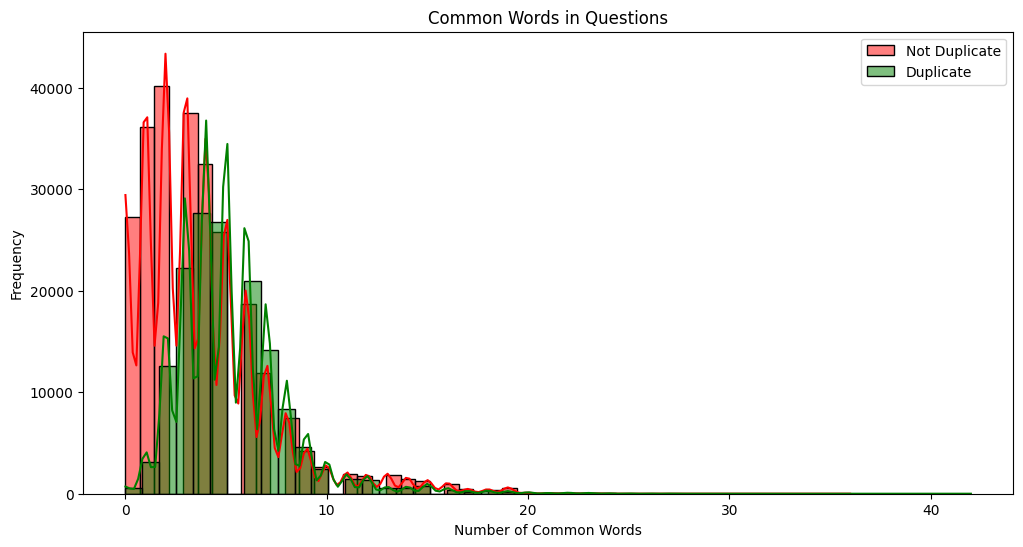

In [7]:
# Fill missing values with empty strings
train_data['question1'].fillna('', inplace=True)
train_data['question2'].fillna('', inplace=True)

# Number of Common Words
def common_words(q1, q2):
    return len(set(q1.split()) & set(q2.split()))

train_data['common_words'] = train_data.apply(lambda row: common_words(row['question1'], row['question2']), axis=1)

plt.figure(figsize=(12, 6))
sns.histplot(train_data[train_data['is_duplicate'] == 0]['common_words'], bins=50, label='Not Duplicate', color='red', kde=True)
sns.histplot(train_data[train_data['is_duplicate'] == 1]['common_words'], bins=50, label='Duplicate', color='green', kde=True)
plt.title('Common Words in Questions')
plt.xlabel('Number of Common Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [8]:
duplicate_stats = train_data[train_data['is_duplicate'] == 1]['common_words'].describe()
non_duplicate_stats = train_data[train_data['is_duplicate'] == 0]['common_words'].describe()
print("Descriptive Statistics for Duplicate Question Pairs (is_duplicate = 1):")
print(duplicate_stats)

print("\nDescriptive Statistics for Non-Duplicate Question Pairs (is_duplicate = 0):")
print(non_duplicate_stats)

Descriptive Statistics for Duplicate Question Pairs (is_duplicate = 1):
count    149263.000000
mean          5.223572
std           2.727881
min           0.000000
25%           3.000000
50%           5.000000
75%           6.000000
max          42.000000
Name: common_words, dtype: float64

Descriptive Statistics for Non-Duplicate Question Pairs (is_duplicate = 0):
count    255027.000000
mean          3.761641
std           3.215477
min           0.000000
25%           2.000000
50%           3.000000
75%           5.000000
max          36.000000
Name: common_words, dtype: float64


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1055324e0>>
Traceback (most recent call last):
  File "/Users/samkocho/Library/Python/3.12/lib/python/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


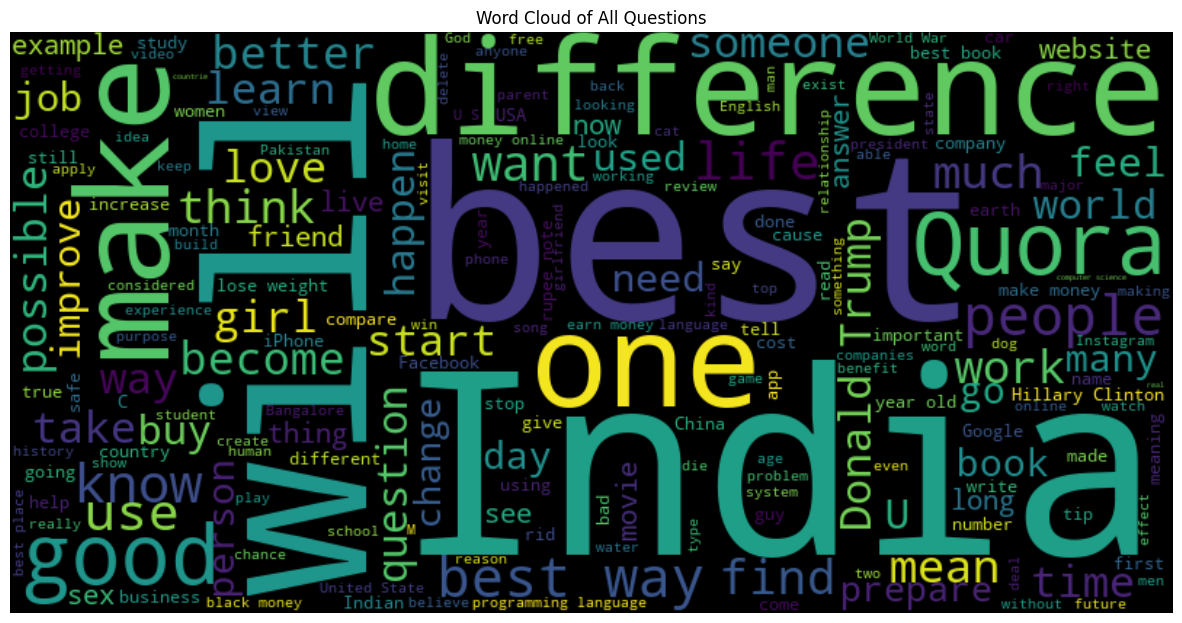

In [9]:
from wordcloud import WordCloud

# Combine all questions for word cloud
all_questions = ' '.join(train_data['question1'].astype(str)) + ' ' + ' '.join(train_data['question2'].astype(str))

wordcloud = WordCloud(width=800, height=400, max_words=200).generate(all_questions)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Questions')
plt.show()


# 2. Feature Engineering

## TF-IDF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
train_data['question1'].fillna('', inplace=True)
train_data['question2'].fillna('', inplace=True)
all_questions = pd.concat([train_data['question1'], train_data['question2']], axis=0)

tfidf = TfidfVectorizer(max_features=10000)
tfidf.fit(all_questions)

# Transform questions into TF-IDF vectors
train_q1_tfidf = tfidf.transform(train_data['question1'])
train_q2_tfidf = tfidf.transform(train_data['question2'])


/var/folders/7d/41zlxmgs4j10fhgnr31g8mnw0000gn/T/ipykernel_7900/2173308181.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['question1'].fillna('', inplace=True)
/var/folders/7d/41zlxmgs4j10fhgnr31g8mnw0000gn/T/ipykernel_7900/2173308181.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

In [12]:
# Create feature vectors by taking the absolute difference of TF-IDF vectors
train_features = abs(train_q1_tfidf - train_q2_tfidf)


- Calculate the absolute difference between the TF-IDF vectors of question1 and question2.
- This captures how similar or different the questions are in terms of word usage and importance.
- The resulting train_features is a sparse matrix where each row represents the feature vector for a pair of questions.

This is a way to represent text as numbers

# 3.1 Model Training (Random Forests)

In [13]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from scipy.stats import randint, uniform


X_train, X_val, y_train, y_val = train_test_split(train_features, train_data['is_duplicate'], test_size=0.2, random_state=42)

# Define the model
model_hp = RandomForestClassifier(random_state=42)

# Define the hyperparameters and their distributions for randomized search
param_dist = {
    'n_estimators': randint(100, 301),
    'max_depth': randint(10, 21),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True, False]
}

# Initialize RandomizedSearchCV with the model and hyperparameters
random_search = RandomizedSearchCV(
    estimator=model_hp,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings that are sampled
    cv=3,
    scoring='neg_log_loss',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit the RandomizedSearchCV to the data
random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f'Best Parameters: {random_search.best_params_}')
print(f'Best Log Loss: {random_search.best_score_}')

# Train the model with the best hyperparameters
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

# Validate the model
val_predictions = best_model.predict_proba(X_val)[:, 1]
print(f'Validation Log Loss: {log_loss(y_val, val_predictions)}')



Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=16, min_samples_leaf=2, min_samples_split=4, n_estimators=174; total time=  21.9s
[CV] END bootstrap=True, max_depth=16, min_samples_leaf=2, min_samples_split=4, n_estimators=174; total time=  21.9s
[CV] END bootstrap=True, max_depth=16, min_samples_leaf=2, min_samples_split=4, n_estimators=174; total time=  22.1s
[CV] END bootstrap=True, max_depth=13, min_samples_leaf=1, min_samples_split=9, n_estimators=288; total time=  30.0s
[CV] END bootstrap=True, max_depth=17, min_samples_leaf=1, min_samples_split=5, n_estimators=203; total time=  30.2s
[CV] END bootstrap=True, max_depth=13, min_samples_leaf=1, min_samples_split=9, n_estimators=288; total time=  30.4s
[CV] END bootstrap=True, max_depth=17, min_samples_leaf=1, min_samples_split=5, n_estimators=203; total time=  30.4s
[CV] END bootstrap=True, max_depth=13, min_samples_leaf=1, min_samples_split=9, n_estimators=288; total time=  30.7s
[C

In [ ]:
# Random Forests w/ GridSearch
from sklearn.model_selection import GridSearchCV

# Define the model
model_hp = RandomForestClassifier(random_state=42)

# Define the hyperparameters and their ranges for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [0, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV with the model and hyperparameters
grid_search = GridSearchCV(estimator=model_hp, param_grid=param_grid, cv=3, scoring='neg_log_loss', verbose=2, n_jobs=-1)

# Fit the GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Log Loss: {grid_search.best_score_}')

# Train the model with the best hyperparameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Validate the model
val_predictions = best_model.predict_proba(X_val)[:, 1]
print(f'Validation Log Loss: {log_loss(y_val, val_predictions)}')


Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 9.5min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 9.5min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 9.6min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 8.3min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 8.4min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=19.5min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=19.6min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; tota

# 3.2 Model Training (XGBoost)

In [ ]:
# import xgboost as xgb
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import log_loss

# X_train_boost, X_val_boost, y_train_boost, y_val_boost = train_test_split(train_features, train_data['is_duplicate'], test_size=0.2, random_state=42)

# model_boost= xgb.XGBClassifier(n_estimators=100, random_state=42)
# model_boost.fit(X_train_boost, y_train_boost)

# val_predictions_boost = model_boost.predict_proba(X_val_boost)[:, 1]
# print(f'Validation Log Loss XGBoost: {log_loss(y_val_boost, val_predictions_boost)}')

import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import log_loss
from scipy.stats import uniform, randint

# Split the data into training and validation sets
X_train_boost, X_val_boost, y_train_boost, y_val_boost = train_test_split(
    train_features, train_data['is_duplicate'], test_size=0.2, random_state=42
)

# Define the XGBoost model
model_boost = xgb.XGBClassifier(random_state=42)

# Define the hyperparameters and their distributions for randomized search
param_dis_boost = {
    'n_estimators': randint(100, 200),  # Reduced range
    'max_depth': randint(3, 7),  # Reduced range
    'learning_rate': uniform(0.01, 0.1),  # Reduced range
    'subsample': uniform(0.8, 0.2),
    'colsample_bytree': uniform(0.8, 0.2),
    'gamma': uniform(0, 0.2)
}


# Initialize RandomizedSearchCV with the model and hyperparameters
random_search_boost = RandomizedSearchCV(
    estimator=model_boost,
    param_distributions=param_dist_boost,
    n_iter=50,  # Number of parameter settings that are sampled
    cv=3,
    scoring='neg_log_loss',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit the RandomizedSearchCV to the data
random_search_boost.fit(X_train_boost, y_train_boost)

# Print the best parameters and the best score
print(f'Best Parameters for XGBoost: {random_search_boost.best_params_}')
print(f'Best Log Loss for XGBoost: {random_search_boost.best_score_}')

# Train the model with the best hyperparameters
best_model_boost = random_search_boost.best_estimator_
best_model_boost.fit(X_train_boost, y_train_boost)

# Validate the model
val_predictions_boost = best_model_boost.predict_proba(X_val_boost)[:, 1]
print(f'Validation Log Loss XGBoost: {log_loss(y_val_boost, val_predictions_boost)}')


Fitting 3 folds for each of 50 candidates, totalling 150 fits


KeyboardInterrupt: 

In [ ]:
#XGBoost with GridSearch
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss


# Define the XGBoost model
model_boost_hp = xgb.XGBClassifier(random_state=42)

# Define the hyperparameters and their ranges for grid search
param_grid_boost = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Initialize GridSearchCV with the model and hyperparameters
grid_search_boost = GridSearchCV(estimator=model_boost_hp, param_grid=param_grid_boost, cv=3, scoring='neg_log_loss', verbose=2, n_jobs=-1)

# Fit the GridSearchCV to the data
grid_search_boost.fit(X_train_boost, y_train_boost)

# Print the best parameters and the best score
print(f'Best Parameters for XGBoost: {grid_search_boost.best_params_}')
print(f'Best Log Loss for XGBoost: {grid_search_boost.best_score_}')

# Train the model with the best hyperparameters
best_model_boost = grid_search_boost.best_estimator_
best_model_boost.fit(X_train_boost, y_train_boost)

# Validate the model
val_predictions_boost = best_model_boost.predict_proba(X_val_boost)[:, 1]
print(f'Validation Log Loss XGBoost: {log_loss(y_val_boost, val_predictions_boost)}')


# 3.3 Model Training (Log)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss

X_train, X_val, y_train, y_val = train_test_split(train_features, train_data['is_duplicate'], test_size=0.2, random_state=42)

model_log = LogisticRegression(random_state=42, max_iter=1000)

param_dist = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2']
}

random_search = RandomizedSearchCV(estimator=model_log, param_distributions=param_dist, n_iter=10, cv=3, scoring='neg_log_loss', verbose=2, n_jobs=-1, random_state=42)

random_search.fit(X_train, y_train)

print(f'Best Parameters: {random_search.best_params_}')
print(f'Best Log Loss: {random_search.best_score_}')

best_model_log = random_search.best_estimator_
best_model_log.fit(X_train, y_train)

val_predictions_log = best_model_log.predict_proba(X_val)[:, 1]
print(f'Validation Log Loss: {log_loss(y_val, val_predictions_log)}')


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .................................C=0.01, penalty=l2; total time=   0.5s
[CV] END .................................C=0.01, penalty=l2; total time=   0.6s
[CV] END .................................C=0.01, penalty=l2; total time=   0.6s
[CV] END ..................................C=0.1, penalty=l2; total time=   1.1s
[CV] END ..................................C=0.1, penalty=l2; total time=   1.1s
[CV] END ..................................C=0.1, penalty=l2; total time=   1.2s
[CV] END ....................................C=1, penalty=l2; total time=   1.1s
[CV] END ....................................C=1, penalty=l2; total time=   1.6s
[CV] END ....................................C=1, penalty=l2; total time=   2.0s
[CV] END ...................................C=10, penalty=l2; total time=   1.6s
[CV] END ...................................C=10, penalty=l2; total time=   1.8s
[CV] END ..................................C=100,

# 4. Prediction

In [ ]:
test_data['question1'].fillna('', inplace=True)
test_data['question2'].fillna('', inplace=True)

# Transform test questions into TF-IDF vectors
test_q1_tfidf = tfidf.transform(test_data['question1'])
test_q2_tfidf = tfidf.transform(test_data['question2'])

# Create test feature vectors
test_features = abs(test_q1_tfidf - test_q2_tfidf)

In [ ]:
test_predictions = model.predict_proba(test_features)[:, 1]
test_predictions_best = best_model.predict_proba(test_features)[:, 1]
test_predictions_best_boost = best_model_boost.predict_proba(test_features)[:, 1]


In [ ]:
test_predictions_best_log = best_model_log.predict_proba(test_features)[:,1]
test_predictions_best_log

array([0.00652498, 0.54301271, 0.4390707 , ..., 0.20997028, 0.69489251,
       0.54534228])

In [ ]:
# Prepare submission file
submission = pd.DataFrame({'test_id': test_data['test_id'], 'is_duplicate': test_predictions})
submission.to_csv('submission.csv', index=False)


In [ ]:
submission = pd.DataFrame({'test_id': test_data['test_id'], 'is_duplicate': test_predictions_best_log})
submission.to_csv('submission_log.csv', index=False)
